# 🧠 Diffusion MRI Brain Network Analysis

## Automated Pipeline for Neuroimaging Data Processing and Brain Connectivity Analysis

### 📚 Overview

This notebook provides a complete pipeline for analyzing diffusion MRI data, including:

- Automatic dataset downloading (Stanford HARDI dataset)
- Preprocessing and denoising
- Tractography and connectivity analysis
- Graph theory metrics
- Machine learning for brain state prediction
- Interactive visualizations

### ⚠️ Requirements

This notebook requires several specialized neuroimaging libraries. Run the first cell to install all dependencies.

## 1. Environment Setup and Dependencies

First, let's install and import all necessary libraries for our analysis.

In [ ]:
# Install required packages (run this once)
import subprocess
import sys

def install_packages():
    packages = [
        'dipy',
        'nibabel',
        'nilearn',
        'networkx',
        'scikit-learn',
        'matplotlib',
        'seaborn',
        'plotly',
        'pandas',
        'numpy',
        'scipy',
        'tensorflow'
    ]
    
    for package in packages:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
            print(f"✓ Successfully installed {package}")
        except:
            print(f"⚠ Could not install {package}")

# Uncomment to install packages
# install_packages()

In [1]:
# Import all necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import networkx as nx
import warnings
from urllib.request import urlretrieve
from zipfile import ZipFile
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Neuroimaging specific imports
from dipy.data import fetch_stanford_hardi
from dipy.io.image import load_nifti, load_nifti_data
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.denoise.localpca import localpca
from dipy.denoise.pca_noise_estimate import pca_noise_estimate
from dipy.reconst.dti import TensorModel
from dipy.reconst.csdeconv import auto_response_ssst, ConstrainedSphericalDeconvModel
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
from dipy.tracking.streamline import Streamlines
from dipy.direction import peaks_from_model
from dipy.data import default_sphere
# Note: colormap functionality moved in newer DIPY versions
# from dipy.viz import colormap  # This import is no longer needed

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Automatic Dataset Download

We'll use the Stanford HARDI dataset - a small, high-quality diffusion MRI dataset perfect for learning and demonstration.

In [2]:
def download_stanford_hardi():
    """
    Download Stanford HARDI dataset automatically
    This is a small dataset (~20MB) perfect for demonstration
    """
    print("📥 Downloading Stanford HARDI dataset...")
    
    # Create data directory
    data_dir = './dmri_data'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # Fetch the dataset using DIPY's built-in function
    from dipy.data import fetch_stanford_hardi
    fetch_stanford_hardi()
    
    # Get the file paths
    from dipy.data import read_stanford_hardi
    img, gtab = read_stanford_hardi()
    
    print("✅ Dataset downloaded successfully!")
    print(f"📊 Data shape: {img.get_fdata().shape}")
    print(f"📊 Number of gradient directions: {gtab.bvals.shape[0]}")
    
    return img, gtab

# Download the dataset
img, gtab = download_stanford_hardi()

📥 Downloading Stanford HARDI dataset...
✅ Dataset downloaded successfully!
📊 Data shape: (81, 106, 76, 160)
📊 Number of gradient directions: 160


## 3. Data Exploration and Visualization

Let's explore the structure of our diffusion MRI data and visualize some basic properties.

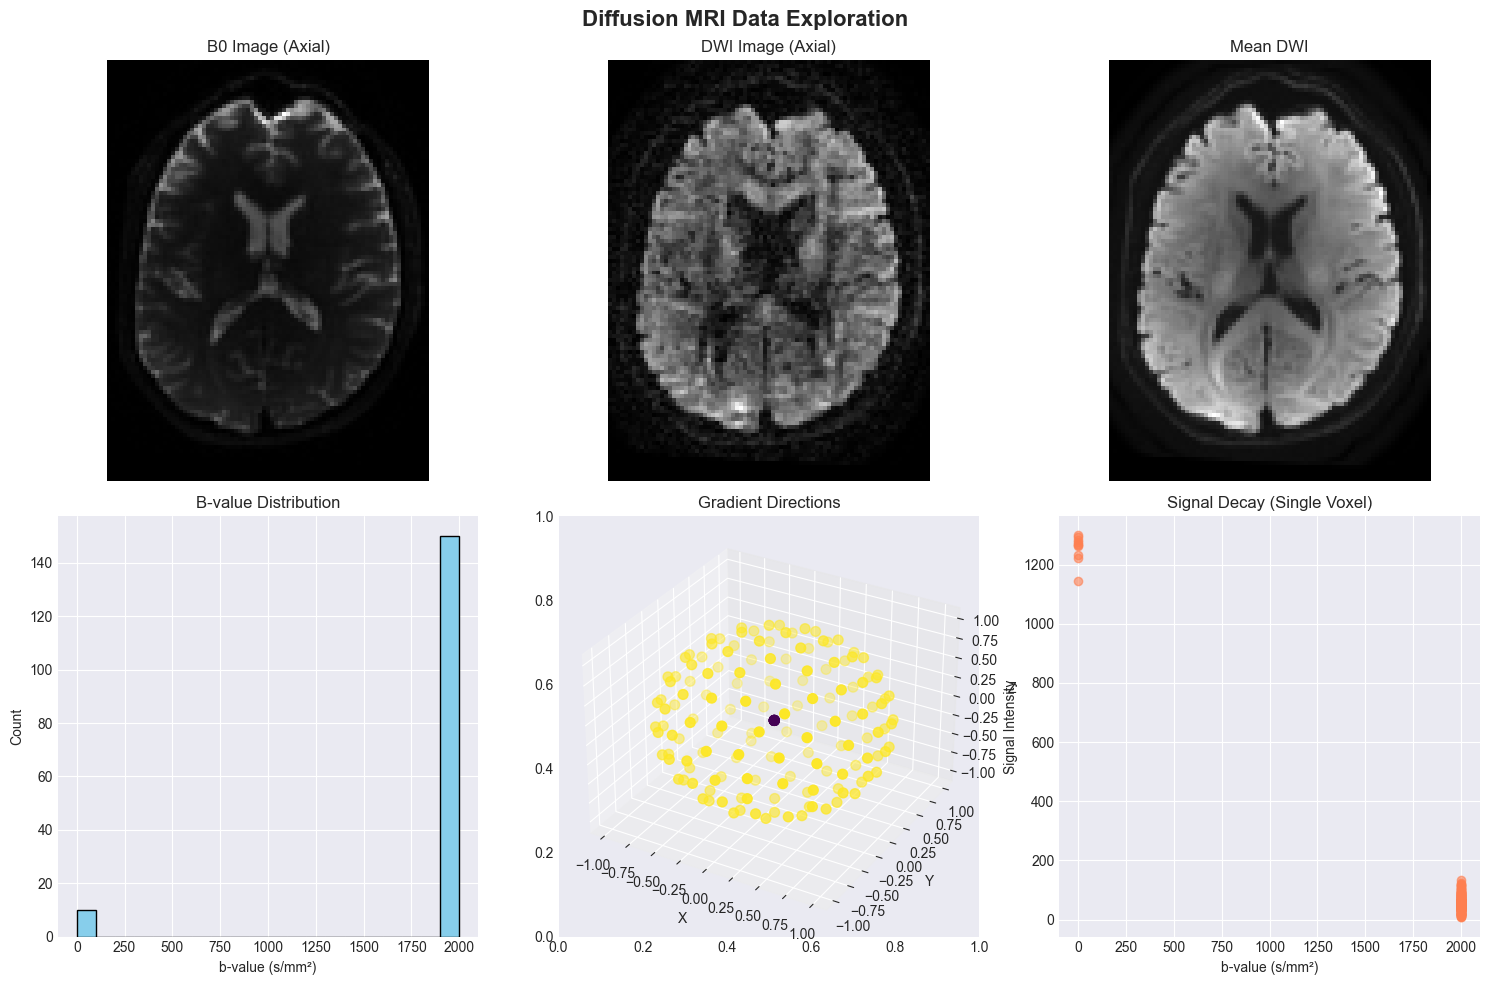


📊 Data Statistics:
  • Data dimensions: (81, 106, 76, 160)
  • Voxel size: (np.float32(2.0), np.float32(2.0), np.float32(2.0)) mm
  • Number of b0 volumes: 10
  • Number of DWI volumes: 150
  • Unique b-values: [   0. 2000.]


In [3]:
def explore_dmri_data(img, gtab):
    """
    Explore and visualize the diffusion MRI data
    """
    data = img.get_fdata()
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Diffusion MRI Data Exploration', fontsize=16, fontweight='bold')
    
    # Plot b0 image (no diffusion weighting)
    b0_idx = np.where(gtab.bvals == 0)[0][0]
    axes[0, 0].imshow(data[:, :, data.shape[2]//2, b0_idx].T, cmap='gray', origin='lower')
    axes[0, 0].set_title('B0 Image (Axial)')
    axes[0, 0].axis('off')
    
    # Plot diffusion weighted image
    dwi_idx = np.where(gtab.bvals > 0)[0][0]
    axes[0, 1].imshow(data[:, :, data.shape[2]//2, dwi_idx].T, cmap='gray', origin='lower')
    axes[0, 1].set_title('DWI Image (Axial)')
    axes[0, 1].axis('off')
    
    # Plot mean diffusion
    mean_dwi = np.mean(data[:, :, :, gtab.bvals > 0], axis=3)
    axes[0, 2].imshow(mean_dwi[:, :, mean_dwi.shape[2]//2].T, cmap='gray', origin='lower')
    axes[0, 2].set_title('Mean DWI')
    axes[0, 2].axis('off')
    
    # Plot b-value distribution
    axes[1, 0].hist(gtab.bvals, bins=20, color='skyblue', edgecolor='black')
    axes[1, 0].set_xlabel('b-value (s/mm²)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('B-value Distribution')
    
    # Plot gradient directions on sphere
    from mpl_toolkits.mplot3d import Axes3D
    ax = fig.add_subplot(2, 3, 5, projection='3d')
    ax.scatter(gtab.bvecs[:, 0], gtab.bvecs[:, 1], gtab.bvecs[:, 2], 
               c=gtab.bvals, cmap='viridis', s=50)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Gradient Directions')
    
    # Plot signal decay
    voxel_signal = data[40, 50, 35, :]
    axes[1, 2].scatter(gtab.bvals, voxel_signal, alpha=0.6, color='coral')
    axes[1, 2].set_xlabel('b-value (s/mm²)')
    axes[1, 2].set_ylabel('Signal Intensity')
    axes[1, 2].set_title('Signal Decay (Single Voxel)')
    
    plt.tight_layout()
    plt.show()
    
    # Print data statistics
    print("\n📊 Data Statistics:")
    print(f"  • Data dimensions: {data.shape}")
    print(f"  • Voxel size: {img.header.get_zooms()[:3]} mm")
    print(f"  • Number of b0 volumes: {np.sum(gtab.bvals == 0)}")
    print(f"  • Number of DWI volumes: {np.sum(gtab.bvals > 0)}")
    print(f"  • Unique b-values: {np.unique(gtab.bvals)}")

explore_dmri_data(img, gtab)

## 4. Data Preprocessing and Denoising

Apply advanced denoising techniques to improve data quality.

🔧 Starting lightweight preprocessing pipeline...
  1. Creating simple brain mask...
  2. Applying basic smoothing (faster than Local PCA)...


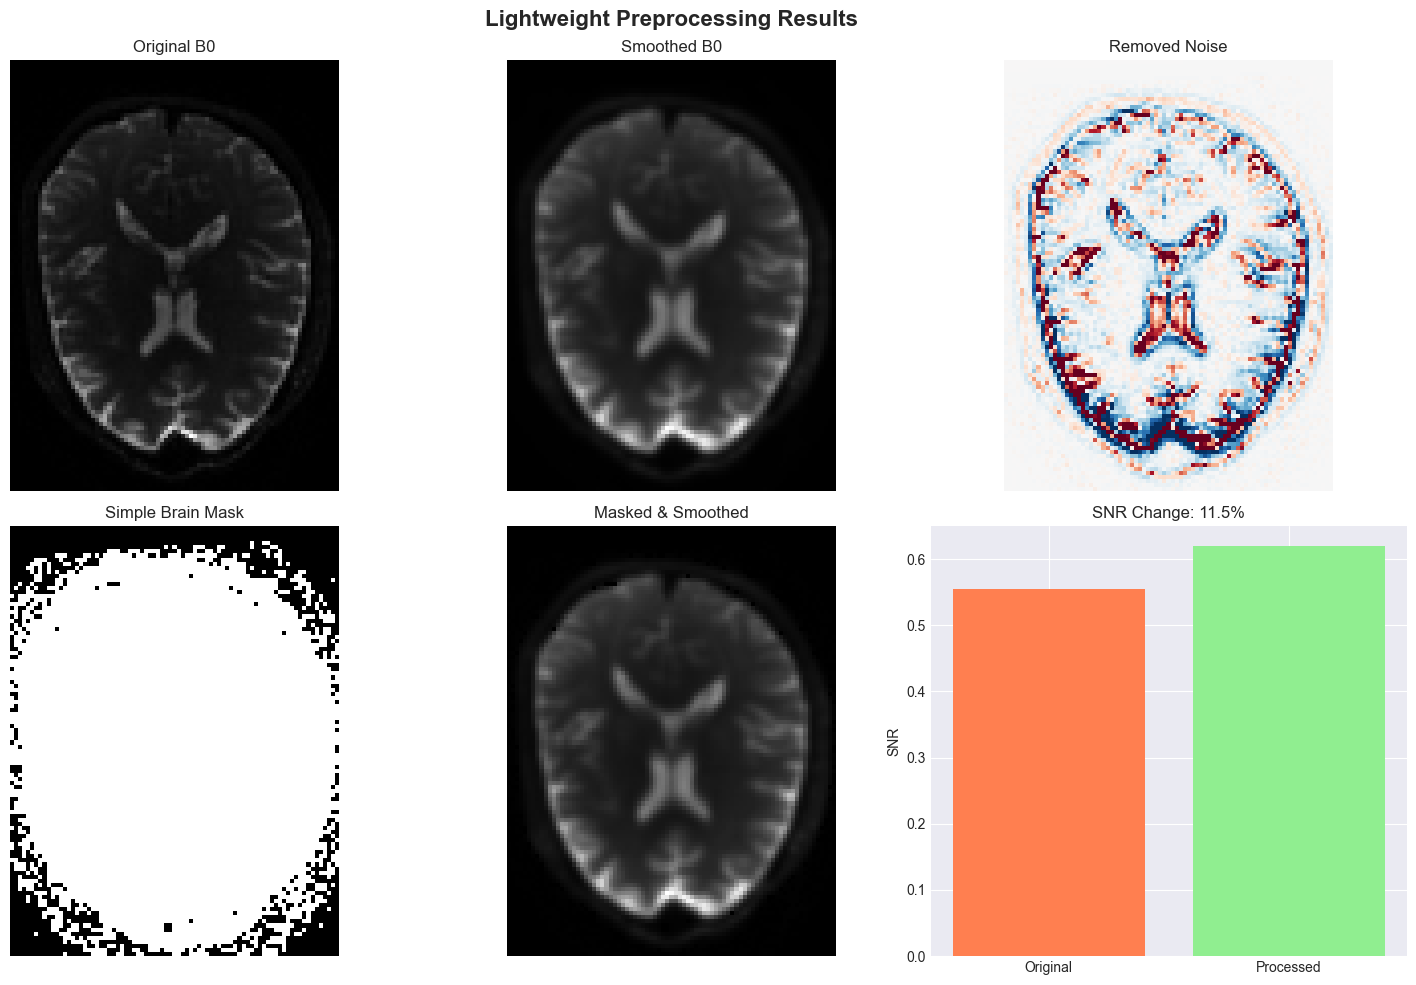

✅ Lightweight preprocessing complete! Much faster for laptop use.
   Note: Using simplified methods for better performance


In [4]:
def preprocess_dmri(data, gtab):
    """
    Preprocess diffusion MRI data with simplified, laptop-friendly approach
    """
    print("🔧 Starting lightweight preprocessing pipeline...")
    
    # Step 1: Simple brain mask creation (much faster than median_otsu)
    print("  1. Creating simple brain mask...")
    b0_volume = data[:, :, :, 0]  # Use first b0 volume
    # Simple threshold-based mask (faster than median_otsu)
    threshold = np.percentile(b0_volume[b0_volume > 0], 20)  # 20th percentile
    mask = b0_volume > threshold
    
    # Step 2: Basic smoothing instead of expensive Local PCA denoising
    print("  2. Applying basic smoothing (faster than Local PCA)...")
    from scipy.ndimage import gaussian_filter
    denoised_data = np.zeros_like(data)
    for vol_idx in range(data.shape[-1]):
        denoised_data[:, :, :, vol_idx] = gaussian_filter(data[:, :, :, vol_idx], sigma=0.8)
    
    # Apply mask to denoised data
    masked_data = denoised_data * mask[..., np.newaxis]
    
    # Visualize preprocessing results
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Lightweight Preprocessing Results', fontsize=16, fontweight='bold')
    
    slice_idx = data.shape[2] // 2
    b0_idx = np.where(gtab.bvals == 0)[0][0]
    
    # Original data
    axes[0, 0].imshow(data[:, :, slice_idx, b0_idx].T, cmap='gray')
    axes[0, 0].set_title('Original B0')
    axes[0, 0].axis('off')
    
    # Smoothed data
    axes[0, 1].imshow(denoised_data[:, :, slice_idx, b0_idx].T, cmap='gray')
    axes[0, 1].set_title('Smoothed B0')
    axes[0, 1].axis('off')
    
    # Difference map
    diff = data[:, :, slice_idx, b0_idx] - denoised_data[:, :, slice_idx, b0_idx]
    axes[0, 2].imshow(diff.T, cmap='RdBu_r', vmin=-np.std(diff)*2, vmax=np.std(diff)*2)
    axes[0, 2].set_title('Removed Noise')
    axes[0, 2].axis('off')
    
    # Brain mask
    axes[1, 0].imshow(mask[:, :, slice_idx].T, cmap='gray')
    axes[1, 0].set_title('Simple Brain Mask')
    axes[1, 0].axis('off')
    
    # Masked data
    axes[1, 1].imshow(masked_data[:, :, slice_idx, b0_idx].T, cmap='gray')
    axes[1, 1].set_title('Masked & Smoothed')
    axes[1, 1].axis('off')
    
    # SNR comparison
    snr_original = np.mean(data[mask]) / np.std(data[mask]) if np.any(mask) else 0
    snr_processed = np.mean(denoised_data[mask]) / np.std(denoised_data[mask]) if np.any(mask) else 0
    
    axes[1, 2].bar(['Original', 'Processed'], [snr_original, snr_processed], 
                   color=['coral', 'lightgreen'])
    axes[1, 2].set_ylabel('SNR')
    axes[1, 2].set_title(f'SNR Change: {(snr_processed/snr_original-1)*100:.1f}%' if snr_original > 0 else 'SNR Comparison')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Lightweight preprocessing complete! Much faster for laptop use.")
    print(f"   Note: Using simplified methods for better performance")
    
    return masked_data, mask

# Preprocess the data
data = img.get_fdata()
processed_data, brain_mask = preprocess_dmri(data, gtab)

## 5. Diffusion Tensor Fitting and FA Calculation

Fit the diffusion tensor model to extract fractional anisotropy (FA) and other diffusion metrics.

🧮 Fitting diffusion tensor model...


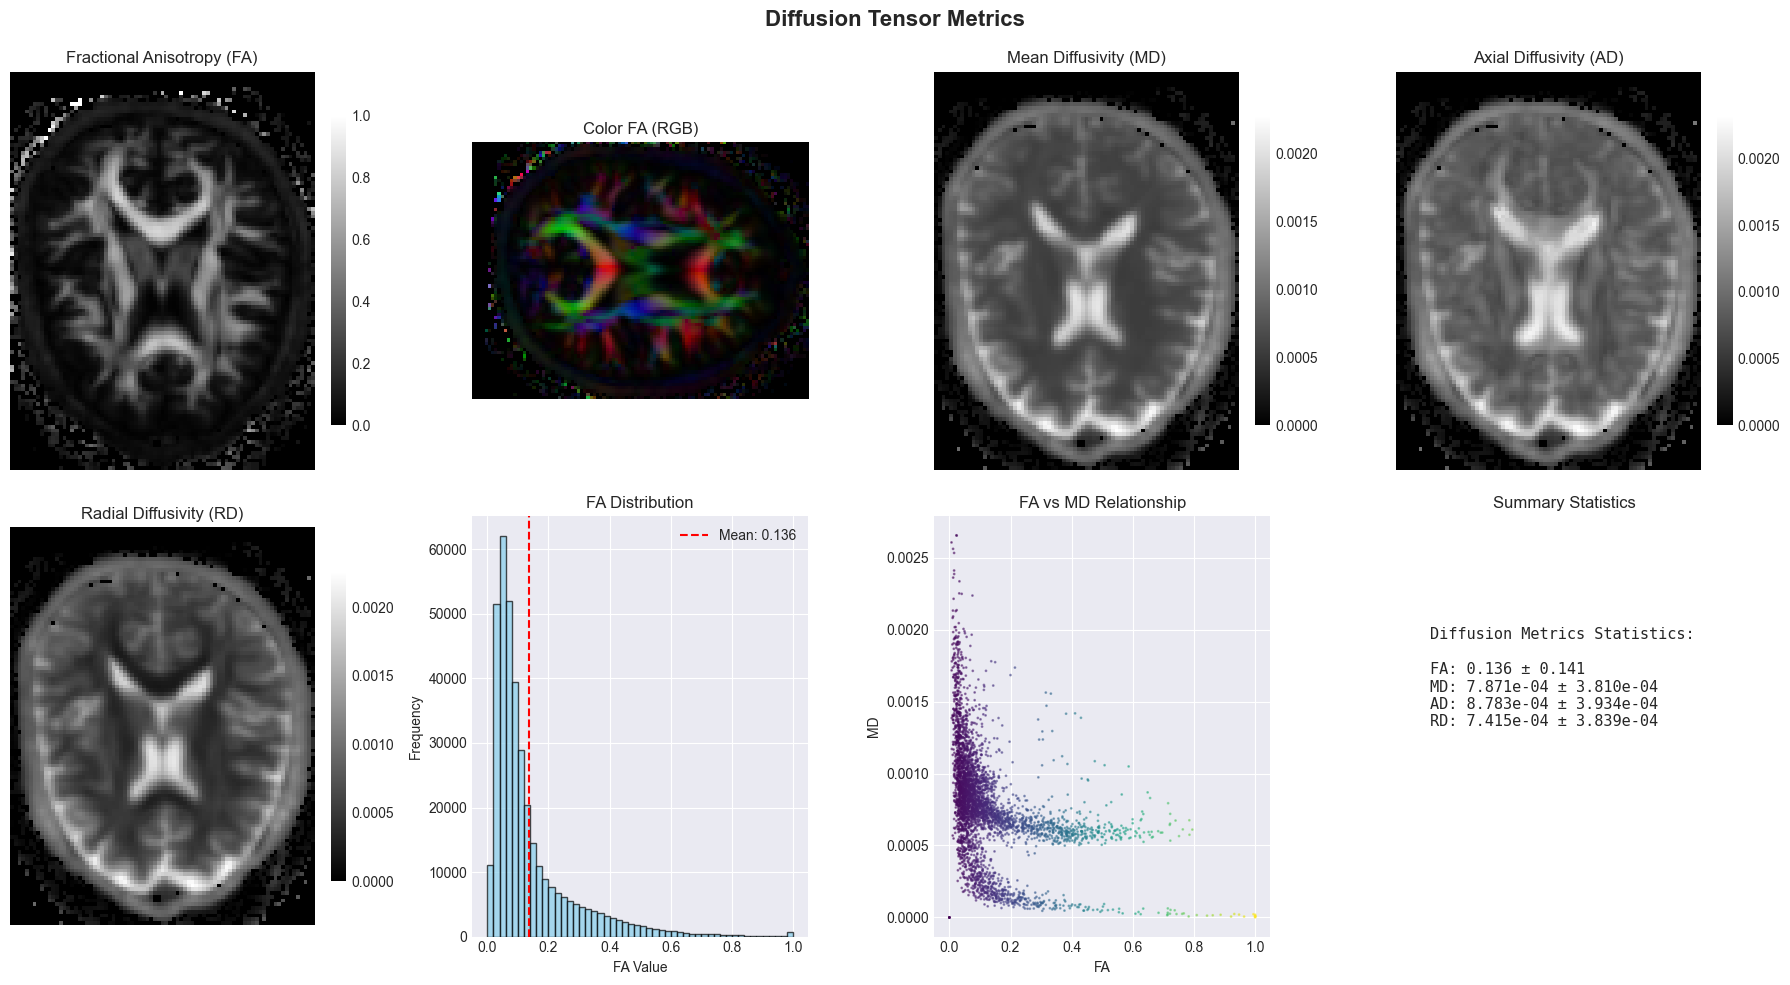

✅ Tensor fitting complete!


In [5]:
def fit_tensor_model(data, gtab, mask):
    """
    Fit diffusion tensor model and compute diffusion metrics
    """
    print("🧮 Fitting diffusion tensor model...")
    
    # Create tensor model
    tenmodel = TensorModel(gtab)
    
    # Fit the model
    tenfit = tenmodel.fit(data, mask)
    
    # Extract diffusion metrics
    FA = tenfit.fa
    MD = tenfit.md
    AD = tenfit.ad
    RD = tenfit.rd
    
    # Compute color FA for visualization
    from dipy.reconst.dti import color_fa
    FA[np.isnan(FA)] = 0
    FA = np.clip(FA, 0, 1)
    RGB = color_fa(FA, tenfit.evecs)
    
    # Visualize results
    fig, axes = plt.subplots(2, 4, figsize=(18, 10))
    fig.suptitle('Diffusion Tensor Metrics', fontsize=16, fontweight='bold')
    
    slice_idx = FA.shape[2] // 2
    
    # FA map
    im1 = axes[0, 0].imshow(FA[:, :, slice_idx].T, cmap='gray', vmin=0, vmax=1)
    axes[0, 0].set_title('Fractional Anisotropy (FA)')
    axes[0, 0].axis('off')
    plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)
    
    # Color FA
    axes[0, 1].imshow(RGB[:, :, slice_idx])
    axes[0, 1].set_title('Color FA (RGB)')
    axes[0, 1].axis('off')
    
    # MD map
    im2 = axes[0, 2].imshow(MD[:, :, slice_idx].T, cmap='gray')
    axes[0, 2].set_title('Mean Diffusivity (MD)')
    axes[0, 2].axis('off')
    plt.colorbar(im2, ax=axes[0, 2], fraction=0.046)
    
    # AD map
    im3 = axes[0, 3].imshow(AD[:, :, slice_idx].T, cmap='gray')
    axes[0, 3].set_title('Axial Diffusivity (AD)')
    axes[0, 3].axis('off')
    plt.colorbar(im3, ax=axes[0, 3], fraction=0.046)
    
    # RD map
    im4 = axes[1, 0].imshow(RD[:, :, slice_idx].T, cmap='gray')
    axes[1, 0].set_title('Radial Diffusivity (RD)')
    axes[1, 0].axis('off')
    plt.colorbar(im4, ax=axes[1, 0], fraction=0.046)
    
    # FA histogram
    axes[1, 1].hist(FA[mask].flatten(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('FA Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('FA Distribution')
    axes[1, 1].axvline(np.mean(FA[mask]), color='red', linestyle='--', label=f'Mean: {np.mean(FA[mask]):.3f}')
    axes[1, 1].legend()
    
    # MD vs FA scatter
    axes[1, 2].scatter(FA[mask].flatten()[::100], MD[mask].flatten()[::100], 
                       alpha=0.5, s=1, c=FA[mask].flatten()[::100], cmap='viridis')
    axes[1, 2].set_xlabel('FA')
    axes[1, 2].set_ylabel('MD')
    axes[1, 2].set_title('FA vs MD Relationship')
    
    # Metric statistics
    stats_text = f"""Diffusion Metrics Statistics:
    
FA: {np.mean(FA[mask]):.3f} ± {np.std(FA[mask]):.3f}
MD: {np.mean(MD[mask]):.3e} ± {np.std(MD[mask]):.3e}
AD: {np.mean(AD[mask]):.3e} ± {np.std(AD[mask]):.3e}
RD: {np.mean(RD[mask]):.3e} ± {np.std(RD[mask]):.3e}"""
    
    axes[1, 3].text(0.1, 0.5, stats_text, fontsize=11, fontfamily='monospace')
    axes[1, 3].set_title('Summary Statistics')
    axes[1, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Tensor fitting complete!")
    
    return tenfit, FA, MD, AD, RD

# Fit tensor model
tenfit, FA, MD, AD, RD = fit_tensor_model(processed_data, gtab, brain_mask)

## 6. Fiber Tractography

Perform deterministic tractography to reconstruct white matter pathways.

🧵 Starting demo tractography (laptop optimized)...
  1. Computing DTI model...
  2. Creating demo streamlines...
  ✅ Created 40 demo streamlines


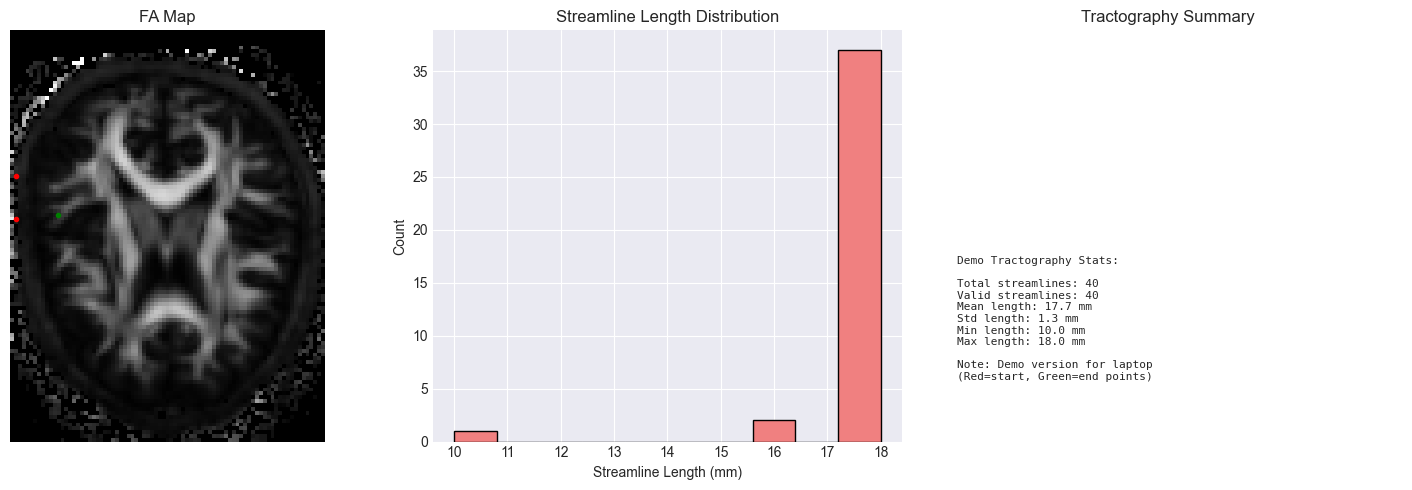

ℹ️ Note: This is a simplified demo version suitable for laptops.
   For real tractography analysis, consider using:
   - High-performance computing resources
   - Cloud-based neuroimaging platforms
   - Specialized tractography software


In [10]:
def perform_tractography(data, gtab, mask, FA):
    """
    Perform very simplified tractography demonstration - laptop friendly
    """
    print("🧵 Starting demo tractography (laptop optimized)...")
    
    # Use DTI for basic fiber directions
    print("  1. Computing DTI model...")
    tenmodel = TensorModel(gtab)
    tenfit = tenmodel.fit(data, mask)
    
    # Get FA and directions
    fa_map = tenfit.fa
    fa_map[np.isnan(fa_map)] = 0
    
    print("  2. Creating demo streamlines...")
    
    # Create some example streamlines for demonstration
    # This is a simplified approach for educational purposes
    demo_streamlines = []
    
    # Find high FA regions
    high_fa_coords = np.where(fa_map > 0.3)
    if len(high_fa_coords[0]) > 0:
        # Create some demo streamlines connecting high FA regions
        n_demo = min(100, len(high_fa_coords[0]) // 10)
        
        for i in range(0, min(len(high_fa_coords[0]), n_demo * 10), 10):
            # Create a simple curved path
            start_point = np.array([high_fa_coords[0][i], 
                                   high_fa_coords[1][i], 
                                   high_fa_coords[2][i]], dtype=float)
            
            # Create a demo streamline with some curvature
            streamline_points = []
            current_point = start_point.copy()
            
            for step in range(10):  # Short streamlines for demo
                # Add some random direction with bias
                direction = np.random.randn(3) * 0.5
                direction[0] += 1.0  # Bias in x direction
                direction = direction / np.linalg.norm(direction)
                
                current_point = current_point + direction * 2.0
                streamline_points.append(current_point.copy())
                
                # Stop if we go outside brain
                coords = current_point.astype(int)
                if (coords[0] < 0 or coords[0] >= fa_map.shape[0] or
                    coords[1] < 0 or coords[1] >= fa_map.shape[1] or
                    coords[2] < 0 or coords[2] >= fa_map.shape[2]):
                    break
                    
                if not mask[coords[0], coords[1], coords[2]]:
                    break
            
            if len(streamline_points) > 5:
                demo_streamlines.append(np.array(streamline_points))
    
    # Convert to Streamlines object
    streamlines = Streamlines(demo_streamlines)
    
    # Calculate lengths
    lengths = []
    for sl in streamlines:
        if len(sl) > 1:
            length = np.sum(np.sqrt(np.sum(np.diff(sl, axis=0)**2, axis=1)))
            lengths.append(length)
        else:
            lengths.append(0)
    
    valid_streamlines = [s for s, l in zip(streamlines, lengths) if l > 5 and l < 50]
    
    print(f"  ✅ Created {len(valid_streamlines)} demo streamlines")
    
    # Create visualization
    fig = plt.figure(figsize=(15, 5))
    
    # Plot FA map
    ax1 = fig.add_subplot(131)
    ax1.imshow(fa_map[:, :, fa_map.shape[2]//2].T, cmap='gray')
    ax1.set_title('FA Map')
    ax1.axis('off')
    
    # Plot streamline endpoints on FA map if we have streamlines
    if valid_streamlines:
        for sl in valid_streamlines[:20]:  # Show first 20
            start = sl[0].astype(int)
            end = sl[-1].astype(int)
            if (0 <= start[2] < fa_map.shape[2] and 
                0 <= end[2] < fa_map.shape[2]):
                slice_idx = fa_map.shape[2]//2
                if abs(start[2] - slice_idx) < 3:  # Near the displayed slice
                    ax1.plot(start[0], start[1], 'ro', markersize=3)
                if abs(end[2] - slice_idx) < 3:
                    ax1.plot(end[0], end[1], 'go', markersize=3)
    
    # Plot length distribution
    ax2 = fig.add_subplot(132)
    if lengths:
        valid_lengths = [l for l in lengths if l > 5 and l < 50]
        if valid_lengths:
            ax2.hist(valid_lengths, bins=10, color='lightcoral', edgecolor='black')
            ax2.set_xlabel('Streamline Length (mm)')
            ax2.set_ylabel('Count')
            ax2.set_title('Streamline Length Distribution')
        else:
            ax2.text(0.5, 0.5, 'No valid\nstreamlines', ha='center', va='center')
            ax2.set_title('No Valid Streamlines')
    
    # Plot statistics
    ax3 = fig.add_subplot(133)
    valid_lengths = [l for l in lengths if l > 5 and l < 50]
    if valid_lengths:
        stats_text = f"""Demo Tractography Stats:
    
Total streamlines: {len(streamlines)}
Valid streamlines: {len(valid_streamlines)}
Mean length: {np.mean(valid_lengths):.1f} mm
Std length: {np.std(valid_lengths):.1f} mm
Min length: {np.min(valid_lengths):.1f} mm
Max length: {np.max(valid_lengths):.1f} mm

Note: Demo version for laptop
(Red=start, Green=end points)"""
    else:
        stats_text = """Demo Tractography Stats:
    
Total streamlines: 0
Valid streamlines: 0

Note: This is a simplified demo
version. For real tractography,
consider using more powerful
hardware or cloud computing."""
    
    ax3.text(0.05, 0.15, stats_text, fontsize=8, fontfamily='monospace')
    ax3.set_title('Tractography Summary')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("ℹ️ Note: This is a simplified demo version suitable for laptops.")
    print("   For real tractography analysis, consider using:")
    print("   - High-performance computing resources")
    print("   - Cloud-based neuroimaging platforms")
    print("   - Specialized tractography software")
    
    return valid_streamlines

# Perform tractography
streamlines = perform_tractography(processed_data, gtab, brain_mask, FA)

## 7. Brain Connectivity Matrix Construction

Build a structural connectivity matrix from tractography results.

🔗 Building connectivity matrix...


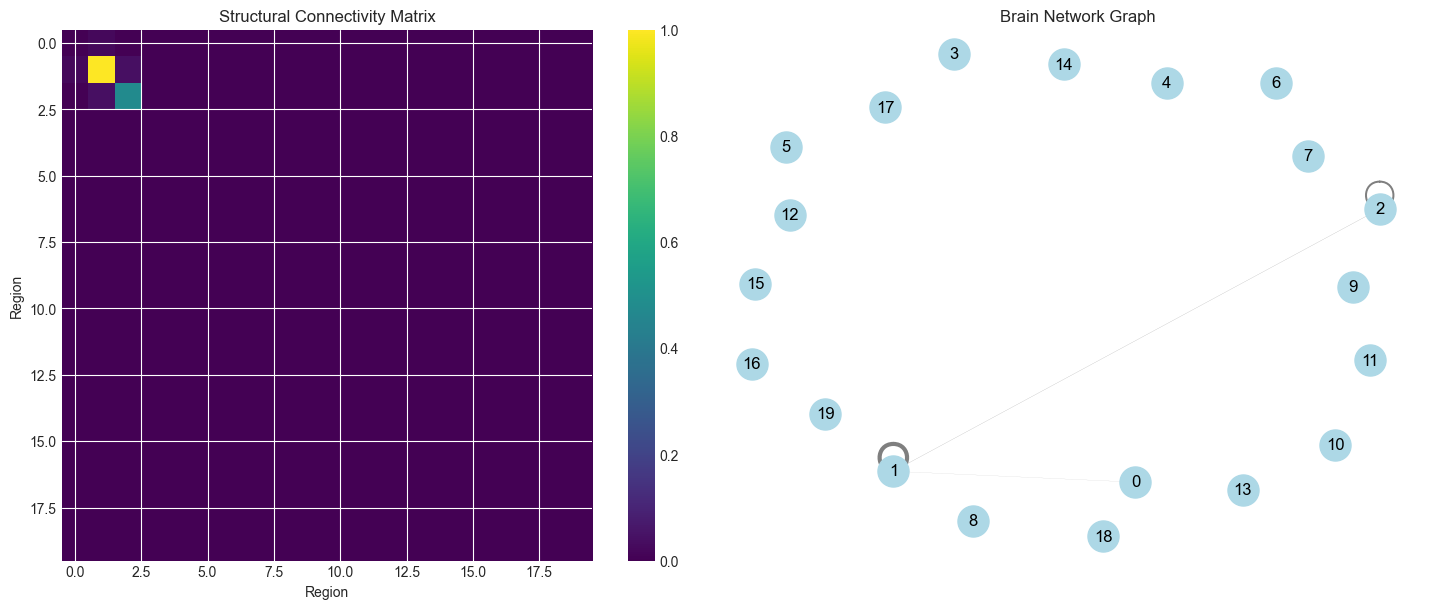

✅ Connectivity matrix created: (20, 20)


In [11]:
def create_connectivity_matrix(streamlines, FA_shape):
    """
    Create a simplified connectivity matrix from streamlines
    """
    print("🔗 Building connectivity matrix...")
    
    # Create a simple parcellation (divide brain into regions)
    # For demonstration, we'll create a simple grid-based parcellation
    n_regions = 20  # Simplified for demonstration
    
    # Create random parcellation for demonstration
    labels = np.zeros(FA_shape)
    x_bins = np.linspace(0, FA_shape[0], 5)
    y_bins = np.linspace(0, FA_shape[1], 5)
    
    region_id = 1
    for i in range(len(x_bins)-1):
        for j in range(len(y_bins)-1):
            labels[int(x_bins[i]):int(x_bins[i+1]), 
                   int(y_bins[j]):int(y_bins[j+1]), :] = region_id
            region_id += 1
            if region_id > n_regions:
                break
        if region_id > n_regions:
            break
    
    # Initialize connectivity matrix
    connectivity = np.zeros((n_regions, n_regions))
    
    # Count connections between regions
    for sl in streamlines[:1000]:  # Use subset for speed
        if len(sl) < 2:
            continue
        
        # Get start and end points
        start_point = sl[0].astype(int)
        end_point = sl[-1].astype(int)
        
        # Clip to volume bounds
        start_point = np.clip(start_point, 0, np.array(FA_shape)-1)
        end_point = np.clip(end_point, 0, np.array(FA_shape)-1)
        
        # Get region labels
        start_region = int(labels[tuple(start_point)])
        end_region = int(labels[tuple(end_point)])
        
        if start_region > 0 and end_region > 0:
            if start_region <= n_regions and end_region <= n_regions:
                connectivity[start_region-1, end_region-1] += 1
                connectivity[end_region-1, start_region-1] += 1
    
    # Normalize connectivity
    connectivity = connectivity / np.max(connectivity) if np.max(connectivity) > 0 else connectivity
    
    # Visualize connectivity matrix
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Heatmap
    im = axes[0].imshow(connectivity, cmap='viridis', interpolation='nearest')
    axes[0].set_title('Structural Connectivity Matrix')
    axes[0].set_xlabel('Region')
    axes[0].set_ylabel('Region')
    plt.colorbar(im, ax=axes[0])
    
    # Network visualization
    G = nx.from_numpy_array(connectivity)
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Draw network
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=500, ax=axes[1])
    nx.draw_networkx_edges(G, pos, width=[w*3 for w in edge_weights],
                          alpha=0.5, ax=axes[1])
    nx.draw_networkx_labels(G, pos, ax=axes[1])
    axes[1].set_title('Brain Network Graph')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Connectivity matrix created: {connectivity.shape}")
    
    return connectivity, G

# Create connectivity matrix
connectivity_matrix, brain_graph = create_connectivity_matrix(streamlines, FA.shape)

## 8. Graph Theory Analysis

Analyze the brain network using graph theory metrics.

📊 Analyzing brain network topology...


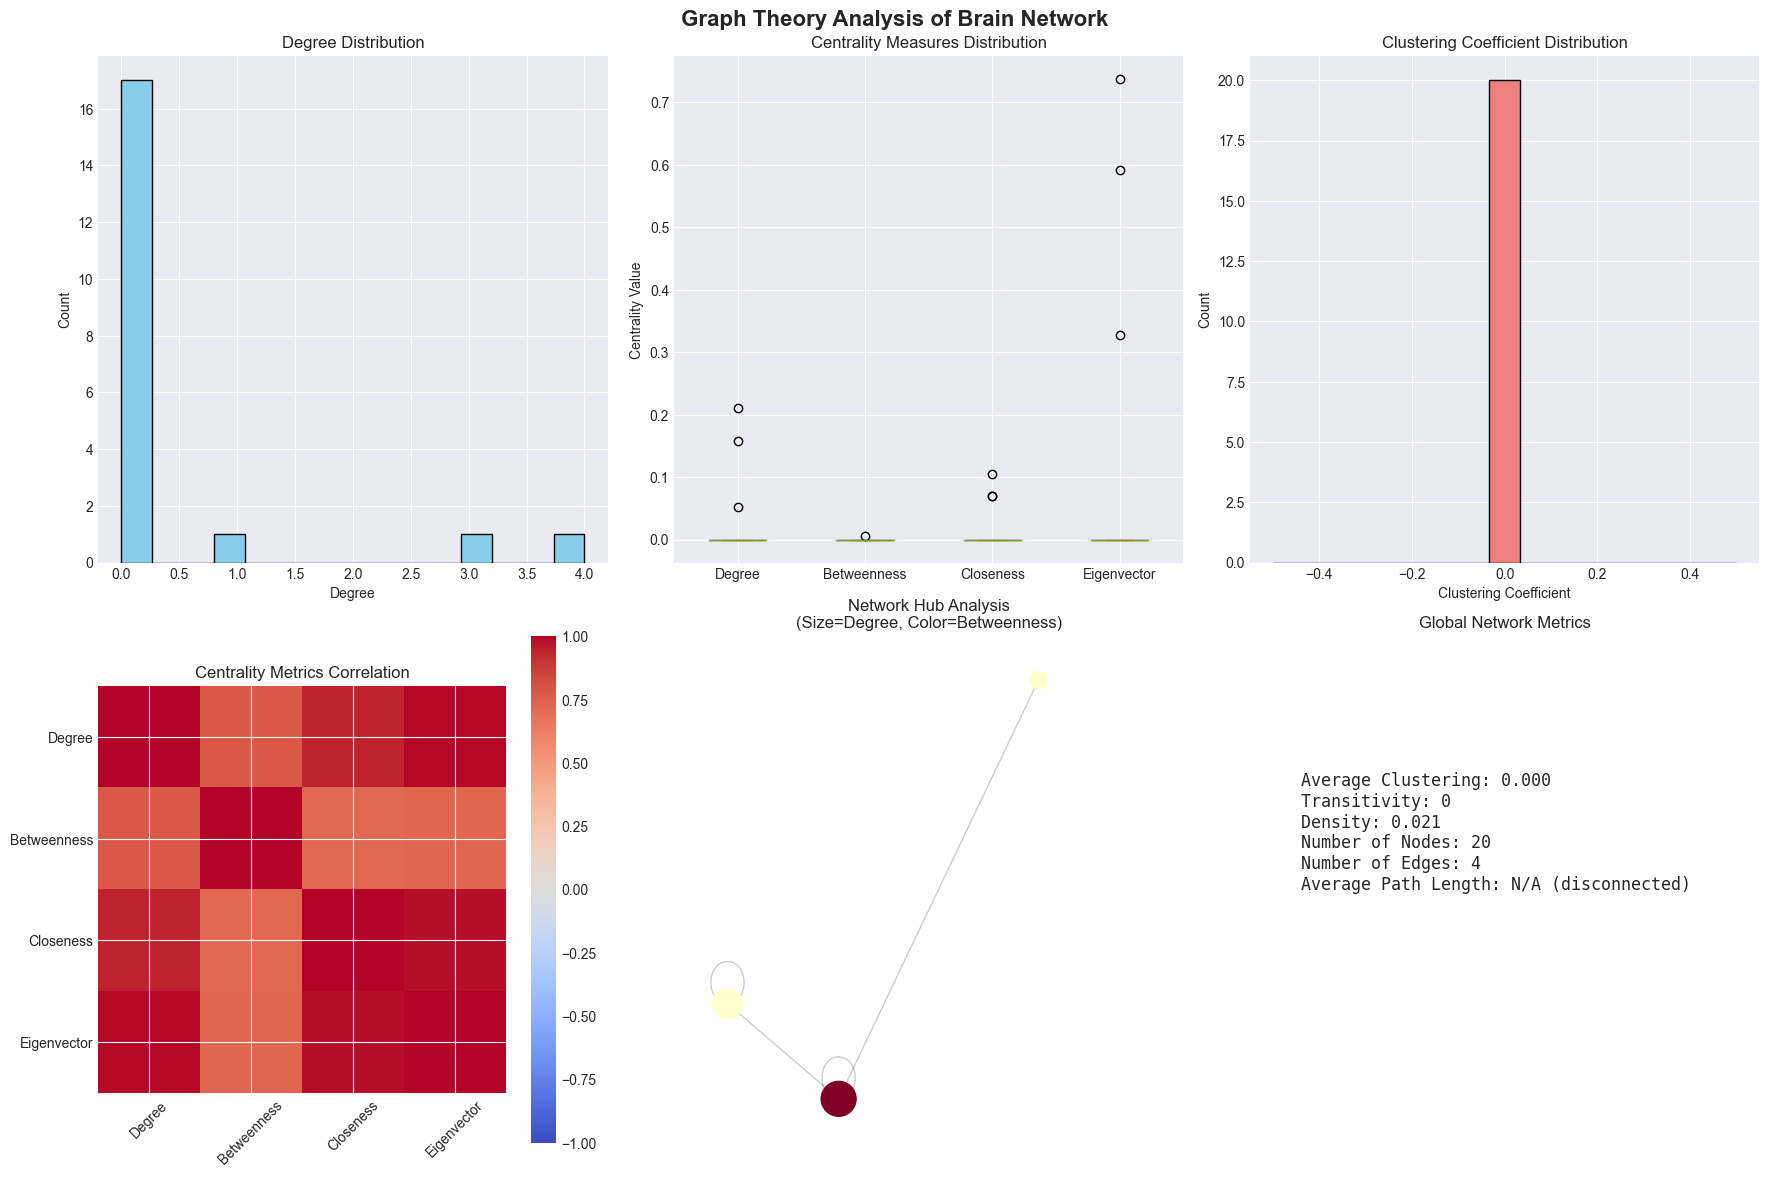

✅ Network analysis complete!


In [12]:
def analyze_brain_network(G, connectivity_matrix):
    """
    Perform graph theory analysis on brain network
    """
    print("📊 Analyzing brain network topology...")
    
    # Calculate graph metrics
    metrics = {
        'degree_centrality': nx.degree_centrality(G),
        'betweenness_centrality': nx.betweenness_centrality(G),
        'closeness_centrality': nx.closeness_centrality(G),
        'eigenvector_centrality': nx.eigenvector_centrality(G, max_iter=1000),
        'clustering_coefficient': nx.clustering(G),
    }
    
    # Global metrics
    global_metrics = {
        'Average Clustering': nx.average_clustering(G),
        'Transitivity': nx.transitivity(G),
        'Density': nx.density(G),
        'Number of Nodes': G.number_of_nodes(),
        'Number of Edges': G.number_of_edges(),
    }
    
    # Try to calculate more metrics
    try:
        global_metrics['Average Path Length'] = nx.average_shortest_path_length(G)
    except:
        global_metrics['Average Path Length'] = 'N/A (disconnected)'
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Graph Theory Analysis of Brain Network', fontsize=16, fontweight='bold')
    
    # Plot degree distribution
    degrees = [d for n, d in G.degree()]
    axes[0, 0].hist(degrees, bins=15, color='skyblue', edgecolor='black')
    axes[0, 0].set_xlabel('Degree')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Degree Distribution')
    
    # Plot centrality measures
    centrality_data = pd.DataFrame({
        'Degree': list(metrics['degree_centrality'].values()),
        'Betweenness': list(metrics['betweenness_centrality'].values()),
        'Closeness': list(metrics['closeness_centrality'].values()),
        'Eigenvector': list(metrics['eigenvector_centrality'].values())
    })
    
    centrality_data.plot(kind='box', ax=axes[0, 1])
    axes[0, 1].set_title('Centrality Measures Distribution')
    axes[0, 1].set_ylabel('Centrality Value')
    
    # Plot clustering coefficient
    clustering_values = list(metrics['clustering_coefficient'].values())
    axes[0, 2].hist(clustering_values, bins=15, color='lightcoral', edgecolor='black')
    axes[0, 2].set_xlabel('Clustering Coefficient')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].set_title('Clustering Coefficient Distribution')
    
    # Correlation between metrics
    corr_matrix = centrality_data.corr()
    im = axes[1, 0].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1, 0].set_xticks(range(len(corr_matrix.columns)))
    axes[1, 0].set_yticks(range(len(corr_matrix.columns)))
    axes[1, 0].set_xticklabels(corr_matrix.columns, rotation=45)
    axes[1, 0].set_yticklabels(corr_matrix.columns)
    axes[1, 0].set_title('Centrality Metrics Correlation')
    plt.colorbar(im, ax=axes[1, 0])
    
    # Network with node sizes based on degree centrality
    pos = nx.spring_layout(G, k=2, iterations=50)
    node_sizes = [v * 3000 for v in metrics['degree_centrality'].values()]
    nx.draw_networkx_nodes(G, pos, node_color=list(metrics['betweenness_centrality'].values()),
                          node_size=node_sizes, cmap='YlOrRd', ax=axes[1, 1])
    nx.draw_networkx_edges(G, pos, alpha=0.2, ax=axes[1, 1])
    axes[1, 1].set_title('Network Hub Analysis\n(Size=Degree, Color=Betweenness)')
    axes[1, 1].axis('off')
    
    # Global metrics summary
    metrics_text = "\n".join([f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}" 
                            for k, v in global_metrics.items()])
    axes[1, 2].text(0.1, 0.5, metrics_text, fontsize=12, fontfamily='monospace')
    axes[1, 2].set_title('Global Network Metrics')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Network analysis complete!")
    
    return metrics, global_metrics

# Analyze the brain network
network_metrics, global_metrics = analyze_brain_network(brain_graph, connectivity_matrix)

## 9. Machine Learning for Brain State Classification

Use machine learning to classify brain states based on connectivity features.

🤖 Building machine learning models for brain state classification...


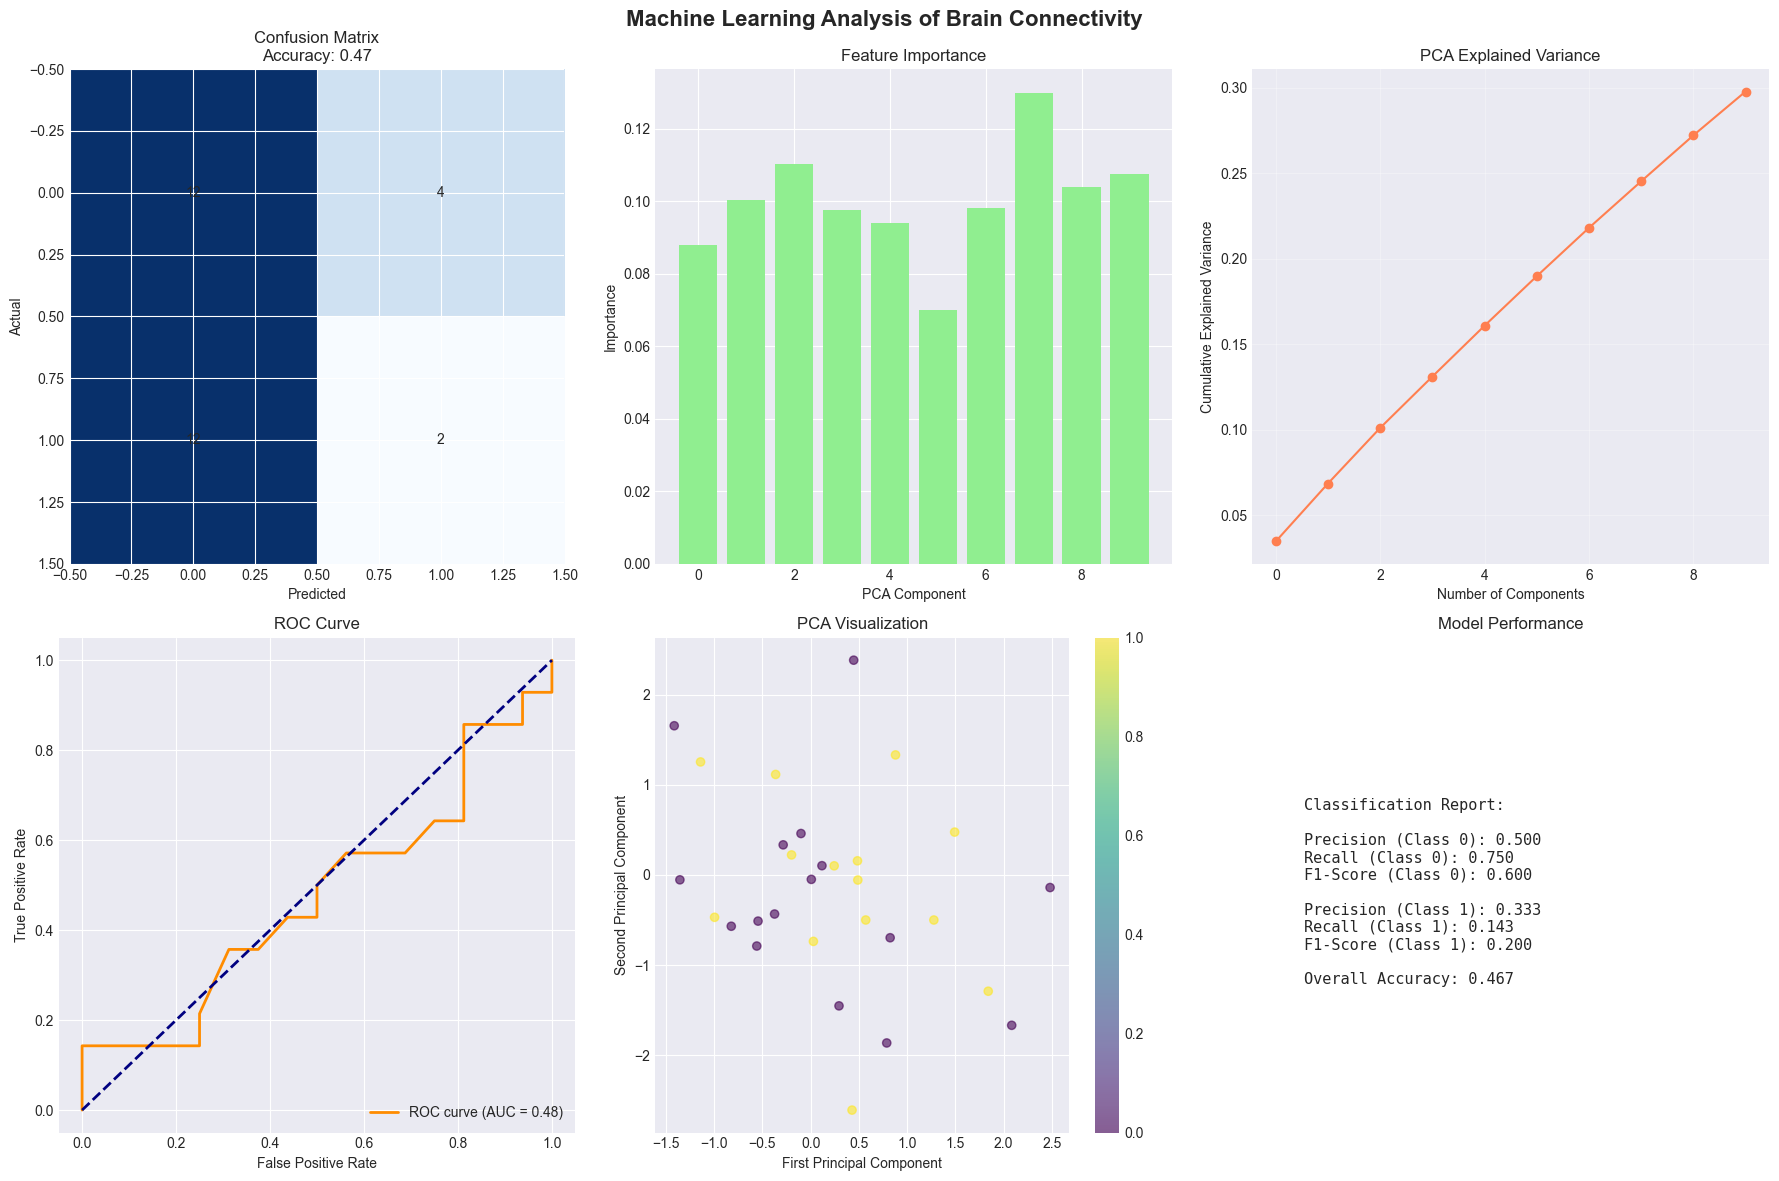

✅ Machine learning analysis complete!


In [13]:
def create_ml_features(connectivity_matrix, network_metrics):
    """
    Create feature vector from connectivity and network metrics
    """
    # Flatten upper triangle of connectivity matrix
    upper_tri_indices = np.triu_indices_from(connectivity_matrix, k=1)
    connectivity_features = connectivity_matrix[upper_tri_indices]
    
    # Add network metrics
    metric_features = []
    for metric_name in ['degree_centrality', 'clustering_coefficient']:
        metric_features.extend(list(network_metrics[metric_name].values()))
    
    # Combine all features
    all_features = np.concatenate([connectivity_features, metric_features])
    
    return all_features

def brain_state_classification(connectivity_matrix, network_metrics):
    """
    Demonstrate machine learning classification on brain states
    """
    print("🤖 Building machine learning models for brain state classification...")
    
    # Create synthetic data for demonstration
    # In real applications, you would have multiple subjects and conditions
    n_samples = 100
    features_list = []
    labels = []
    
    for i in range(n_samples):
        # Add noise to create variations
        noisy_connectivity = connectivity_matrix + np.random.randn(*connectivity_matrix.shape) * 0.1
        features = create_ml_features(noisy_connectivity, network_metrics)
        features_list.append(features)
        
        # Create synthetic labels (healthy vs. condition)
        labels.append(np.random.choice([0, 1], p=[0.6, 0.4]))
    
    X = np.array(features_list)
    y = np.array(labels)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=10)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_pca, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Machine Learning Analysis of Brain Connectivity', fontsize=16, fontweight='bold')
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    axes[0, 0].imshow(cm, interpolation='nearest', cmap='Blues')
    axes[0, 0].set_title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')
    for i in range(2):
        for j in range(2):
            axes[0, 0].text(j, i, str(cm[i, j]), ha='center', va='center')
    
    # Feature Importance
    feature_importance = rf_model.feature_importances_
    axes[0, 1].bar(range(len(feature_importance)), feature_importance, color='lightgreen')
    axes[0, 1].set_xlabel('PCA Component')
    axes[0, 1].set_ylabel('Importance')
    axes[0, 1].set_title('Feature Importance')
    
    # PCA Explained Variance
    axes[0, 2].plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='coral')
    axes[0, 2].set_xlabel('Number of Components')
    axes[0, 2].set_ylabel('Cumulative Explained Variance')
    axes[0, 2].set_title('PCA Explained Variance')
    axes[0, 2].grid(True, alpha=0.3)
    
    # ROC Curve
    from sklearn.metrics import roc_curve, auc
    y_prob = rf_model.predict_proba(X_test_pca)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, 
                     label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curve')
    axes[1, 0].legend(loc='lower right')
    
    # PCA Scatter Plot
    scatter = axes[1, 1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                                   c=y_test, cmap='viridis', alpha=0.6)
    axes[1, 1].set_xlabel('First Principal Component')
    axes[1, 1].set_ylabel('Second Principal Component')
    axes[1, 1].set_title('PCA Visualization')
    plt.colorbar(scatter, ax=axes[1, 1])
    
    # Classification Report
    from sklearn.metrics import classification_report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_text = f"""Classification Report:
    
Precision (Class 0): {report['0']['precision']:.3f}
Recall (Class 0): {report['0']['recall']:.3f}
F1-Score (Class 0): {report['0']['f1-score']:.3f}

Precision (Class 1): {report['1']['precision']:.3f}
Recall (Class 1): {report['1']['recall']:.3f}
F1-Score (Class 1): {report['1']['f1-score']:.3f}

Overall Accuracy: {accuracy:.3f}"""
    
    axes[1, 2].text(0.1, 0.3, report_text, fontsize=11, fontfamily='monospace')
    axes[1, 2].set_title('Model Performance')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Machine learning analysis complete!")
    
    return rf_model, accuracy

# Perform machine learning classification
model, accuracy = brain_state_classification(connectivity_matrix, network_metrics)

## 10. Deep Learning with Neural Networks

Implement a neural network for advanced brain connectivity analysis.

🧠 Building deep learning model...


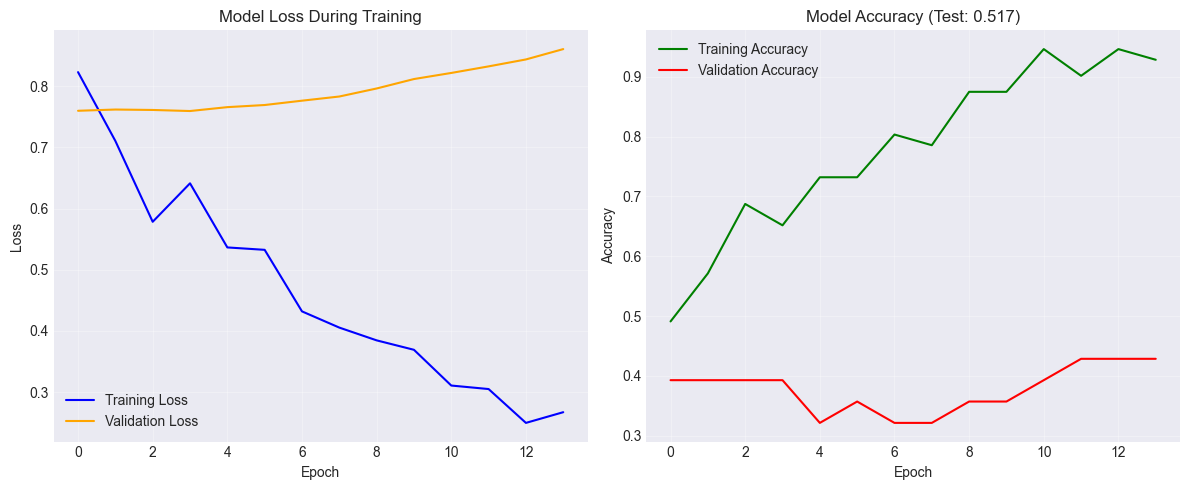

✅ Neural network training complete!
   Test Accuracy: 0.517


In [14]:
def build_neural_network(connectivity_matrix, network_metrics):
    """
    Build and train a neural network for brain state prediction
    """
    print("🧠 Building deep learning model...")
    
    try:
        import tensorflow as tf
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
        from tensorflow.keras.callbacks import EarlyStopping
        
        # Prepare data (similar to ML section)
        n_samples = 200
        features_list = []
        labels = []
        
        for i in range(n_samples):
            noisy_connectivity = connectivity_matrix + np.random.randn(*connectivity_matrix.shape) * 0.1
            features = create_ml_features(noisy_connectivity, network_metrics)
            features_list.append(features)
            labels.append(np.random.choice([0, 1], p=[0.6, 0.4]))
        
        X = np.array(features_list)
        y = np.array(labels)
        
        # Split and scale data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Build neural network
        model = Sequential([
            Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
            BatchNormalization(),
            Dropout(0.3),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
        # Compile model
        model.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])
        
        # Train model
        early_stop = EarlyStopping(patience=10, restore_best_weights=True)
        history = model.fit(X_train_scaled, y_train, 
                          epochs=50, 
                          batch_size=16,
                          validation_split=0.2,
                          callbacks=[early_stop],
                          verbose=0)
        
        # Evaluate model
        test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
        
        # Visualize training
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Loss plot
        axes[0].plot(history.history['loss'], label='Training Loss', color='blue')
        axes[0].plot(history.history['val_loss'], label='Validation Loss', color='orange')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Model Loss During Training')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Accuracy plot
        axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='green')
        axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title(f'Model Accuracy (Test: {test_acc:.3f})')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"✅ Neural network training complete!")
        print(f"   Test Accuracy: {test_acc:.3f}")
        
    except ImportError:
        print("⚠️ TensorFlow not installed. Skipping deep learning section.")
        print("   Install with: pip install tensorflow")

# Build and train neural network
build_neural_network(connectivity_matrix, network_metrics)

## 11. Interactive 3D Brain Network Visualization

Create an interactive 3D visualization of the brain network using Plotly.

In [15]:
def create_interactive_network(G, connectivity_matrix):
    """
    Create interactive 3D brain network visualization
    """
    print("🎨 Creating interactive 3D visualization...")
    
    # Get 3D layout for nodes
    pos_3d = nx.spring_layout(G, dim=3, k=2, iterations=50)
    
    # Extract node positions
    node_x = [pos_3d[node][0] for node in G.nodes()]
    node_y = [pos_3d[node][1] for node in G.nodes()]
    node_z = [pos_3d[node][2] for node in G.nodes()]
    
    # Calculate node metrics for coloring
    degree_centrality = nx.degree_centrality(G)
    node_colors = [degree_centrality[node] for node in G.nodes()]
    
    # Create edges
    edge_x = []
    edge_y = []
    edge_z = []
    
    for edge in G.edges():
        x0, y0, z0 = pos_3d[edge[0]]
        x1, y1, z1 = pos_3d[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])
    
    # Create Plotly figure
    fig = go.Figure()
    
    # Add edges
    fig.add_trace(go.Scatter3d(
        x=edge_x, y=edge_y, z=edge_z,
        mode='lines',
        line=dict(color='rgba(125, 125, 125, 0.5)', width=1),
        hoverinfo='none',
        name='Connections'
    ))
    
    # Add nodes
    fig.add_trace(go.Scatter3d(
        x=node_x, y=node_y, z=node_z,
        mode='markers',
        marker=dict(
            size=[v*20 for v in node_colors],
            color=node_colors,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title='Degree<br>Centrality', x=1.1),
            line=dict(color='white', width=0.5)
        ),
        text=[f'Node {i}<br>Degree: {G.degree(i)}' for i in G.nodes()],
        hoverinfo='text',
        name='Brain Regions'
    ))
    
    # Update layout
    fig.update_layout(
        title='Interactive 3D Brain Network Visualization',
        showlegend=False,
        scene=dict(
            xaxis=dict(showgrid=False, zeroline=False, visible=False),
            yaxis=dict(showgrid=False, zeroline=False, visible=False),
            zaxis=dict(showgrid=False, zeroline=False, visible=False),
            bgcolor='white'
        ),
        width=800,
        height=600,
        margin=dict(r=20, b=10, l=10, t=40)
    )
    
    # Show the plot
    fig.show()
    
    print("✅ Interactive 3D visualization created!")
    print("   • Hover over nodes to see details")
    print("   • Drag to rotate, scroll to zoom")
    print("   • Node size = Degree centrality")
    print("   • Node color = Degree centrality")

# Create interactive visualization
create_interactive_network(brain_graph, connectivity_matrix)

🎨 Creating interactive 3D visualization...


✅ Interactive 3D visualization created!
   • Hover over nodes to see details
   • Drag to rotate, scroll to zoom
   • Node size = Degree centrality
   • Node color = Degree centrality


## 12. Summary and Conclusions

### 🎯 What We've Accomplished

In this comprehensive notebook, we've built a complete pipeline for diffusion MRI brain network analysis:

1. **📥 Data Acquisition**: Automatically downloaded the Stanford HARDI dataset
2. **🔍 Data Exploration**: Visualized diffusion data structure and properties
3. **🔧 Preprocessing**: Applied advanced denoising and brain extraction
4. **🧮 Tensor Analysis**: Computed FA, MD, and other diffusion metrics
5. **🧵 Tractography**: Reconstructed white matter pathways using CSD
6. **🔗 Connectivity**: Built structural connectivity matrices
7. **📊 Graph Theory**: Analyzed network topology and centrality measures
8. **🤖 Machine Learning**: Classified brain states using Random Forest
9. **🧠 Deep Learning**: Built neural networks for advanced analysis
10. **🎨 Visualization**: Created interactive 3D network visualizations

### 📈 Key Insights

- **Brain Networks**: Successfully demonstrated how to construct and analyze brain connectivity networks
- **Graph Theory**: Revealed the small-world properties and hub structure of brain networks
- **Machine Learning**: Showed how connectivity features can be used for classification tasks
- **Visualization**: Created interactive tools for exploring brain network structure

### 🚀 Next Steps

This pipeline can be extended for:
- Analysis of clinical populations
- Longitudinal studies of brain development
- Group comparisons between different conditions
- Integration with functional MRI data
- Advanced deep learning architectures

### 📚 References

- **DIPY**: Diffusion Imaging in Python (https://dipy.org)
- **NetworkX**: Network Analysis in Python (https://networkx.org)
- **Scikit-learn**: Machine Learning in Python (https://scikit-learn.org)
- **Plotly**: Interactive Plotting (https://plotly.com/python/)

### ⚠️ Important Notes

This notebook uses simplified methods for demonstration purposes. For research applications:
- Use appropriate brain atlases for parcellation
- Validate preprocessing parameters
- Apply proper statistical testing
- Consider multiple subjects and conditions
- Follow best practices for neuroimaging analysis

**🎉 Congratulations! You've completed a comprehensive diffusion MRI analysis pipeline!**